#### 1. 이 과정을 돌이켜 보면 20번의 에포크 동안 모델을 훈련하여 검증 점수가 상승하는 지점을 확인
#### 2. 그 다음 모델을 과대적합되지 않는 에포크만큼 다시 훈련
#### ?? 모델을 두 번씩 훈련하지 않고 한번에 끝낼 수는 없을까? ==> keras.callback

### 콜백(callback)
- 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스
- fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용
- **ModelCheckpoint** 콜백은 기본적으로 최상의 검증 점수를 만드는 모델을 자동 저장

### 기존 Code

In [10]:
import tensorflow as tf
from tensorflow import keras

from tensorflow import keras
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()

from sklearn.model_selection import train_test_split
train_scaled = train_input/255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)


def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu', name='hidden'))
    
    if a_layer:
        model.add(a_layer)
    
    model.add(keras.layers.Dense(10, activation='softmax', name='output'))
    
    return model  

In [11]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

## [best-model.h5]로 파일 이름을 지정하여 최상의 검증 점수의 모델을 저장.
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

### 모델이 훈련한 후, [best-model.h5] 에 최상의 검증 점수 저장.
### 이 모델을 load_model() 함수로 다시 읽어서 예측 수행.

In [12]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3328 - accuracy: 0.8859


[0.33279338479042053, 0.8859166502952576]

### 조기종료(early stopping)
- ModelCheckpoint 콜백이 가장 낮은 검증 점수 모델 자동 저장
- 하지만 20번의 에포크 동안 훈련 지속. => 검증 점수가 상승하기 시작하면 과대적합이기에 훈련을 할 필요가 없다.
- 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다. => 조기종료
- 조기 종료는 훈련 에포크의 횟수를 제한하는 역할이자만 모델이 과대적합되는 것을 막아 주기 때문에, 규제 방법 중 하나.

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

## [best-model.h5]로 파일 이름을 지정하여 최상의 검증 점수의 모델을 저장.
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), 
          callbacks=[checkpoint_cb, early_stopping_cb])

- patience 매개변수: 검증 점수가 향상되지 않더라도 참을 에포크 횟수 지정
- restore_best_weights = True, => 가장 낮은 검증 손실을 낸 모델 파라미터롤 되돌림.
- EarlyStopping 콜백 & ModelCheckpoint 콜백과 함께 사용 시
    - 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련 중지
    - 훈련 중지 후, 현재 모델의 파라미터를 최상의 파라미터로 되돌림.

In [14]:
print(early_stopping_cb.stopped_epoch)

7


#### 7번째 에포크에서 훈련이 중지 => 5번째가 최상의 모델.(patience = 2로 지정)

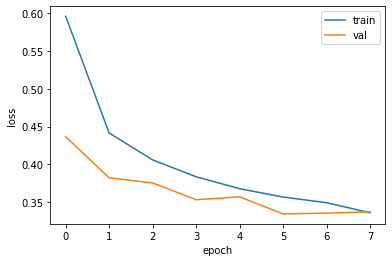

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [17]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3345 - accuracy: 0.8797


[0.3345144987106323, 0.8796666860580444]